In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, LambdaCallback
from tensorflow.keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools 
import datetime

import cv2
import os
import io


In [15]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 200


for label in labels:
    trainPath = os.path.join(r"C:\Users\hp\OneDrive\Desktop\archive\Training",label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join(r"C:\Users\hp\OneDrive\Desktop\archive\Testing",label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))


x_train = np.array(x_train) / 255.0 # normalize Images into range 0 to 1.
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 295.09it/s]


(5712, 200, 200, 3)
(1311, 200, 200, 3)


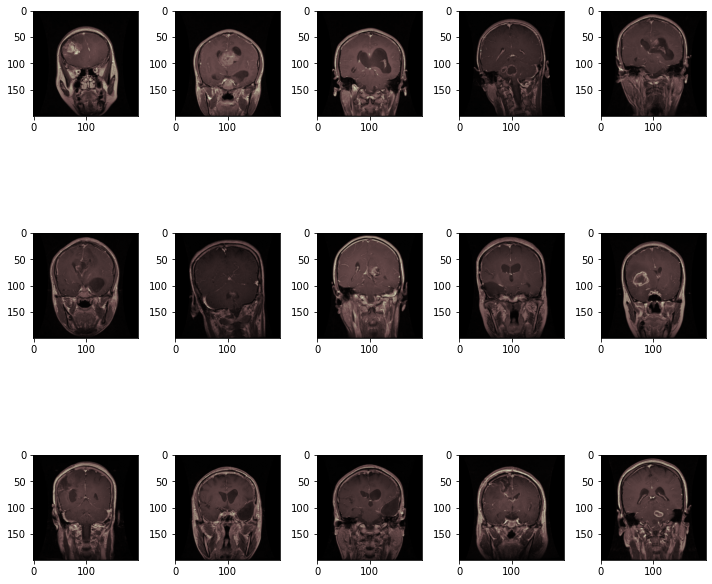

In [16]:
images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [17]:
x_train, y_train = shuffle(x_train,y_train, random_state=42) 

y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)

(1143, 200, 200, 3)


In [18]:
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(x_train)

In [19]:
net = ResNet50(
    weights='imagenet', # Load weights pre-trained on ImageNet.
     include_top=False, # Do not include the ImageNet classifier at the top.
     input_shape=(image_size,image_size,3))

In [20]:
# Import Keras and the Adam optimizer
from tensorflow.keras.optimizers import Adam

#compile our model.
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 200, 200, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 206, 206, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 100, 100, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 100, 100, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 100, 100, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 102, 102, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 50, 50, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 50, 50, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 50, 50, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 50, 50, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 50, 50, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 50, 50, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 50, 50, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 50, 50, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 50, 50, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 23,542,788 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [31]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import io
import itertools
from sklearn.metrics import confusion_matrix
import datetime
import os
import shutil

# Example: Replace with actual data loading and preprocessing
# x_train, y_train = ...
# x_test, y_test = ...

# Use a smaller subset of data for demonstration (e.g., 1000 samples)
x_train = x_train[:1000]
y_train = y_train[:1000]
x_test = x_test[:300]
y_test = y_test[:300]

# Define your input shape
input_shape = (200, 200, 3)  # Update this according to your data

# Assuming labels is defined and contains class names
class_names = list(labels)

# Debugging: Print shapes to verify initial shapes
print("Initial x_train shape:", x_train.shape)
print("Initial y_train shape:", y_train.shape)
print("Initial x_test shape:", x_test.shape)
print("Initial y_test shape:", y_test.shape)

# Ensure y_train and y_test are reshaped to match the sample size of x_train and x_test
num_samples_train = x_train.shape[0]
num_samples_test = x_test.shape[0]

# Reshape y_train and y_test to (num_samples, -1)
y_train_flat = y_train.reshape((num_samples_train, -1))
y_test_flat = y_test.reshape((num_samples_test, -1))

# Further debug: Print shapes to verify reshaping
print("y_train reshaped shape:", y_train_flat.shape)
print("y_test reshaped shape:", y_test_flat.shape)

# Flatten the reshaped labels to 1D before one-hot encoding
y_train_flat = y_train_flat.reshape(-1, y_train_flat.shape[-1])
y_test_flat = y_test_flat.reshape(-1, y_test_flat.shape[-1])

# Ensure labels are one-hot encoded
NUM_CLASSES = y_train_flat.shape[-1]
y_train = tf.keras.utils.to_categorical(y_train_flat.argmax(axis=1), num_classes=NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test_flat.argmax(axis=1), num_classes=NUM_CLASSES)

# Further debug: Print shapes to verify one-hot encoding
print("y_train one-hot shape:", y_train.shape)
print("y_test one-hot shape:", y_test.shape)

# Function to convert a plot to an image tensor
def plot_to_image(figure):
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    return image

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    threshold = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return figure

# Function to log the confusion matrix at the end of each epoch
def log_confusion_matrix(epoch, logs):
    predictions = np.argmax(model.predict(x_test), axis=1)
    cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)

    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# Define the logging directory
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Set up the file writer for logging confusion matrix
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

# Remove previous log folder using shutil for cross-platform compatibility
shutil.rmtree('logs', ignore_errors=True)

# TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Callback for logging confusion matrix
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

# Define a simple model for demonstration purposes
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),  # Use Input layer for the input shape
    tf.keras.layers.Flatten(),  # Flatten the input
    tf.keras.layers.Dense(64, activation='relu'),  # Reduced units for simplicity
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile and train the model
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), callbacks=[tensorboard_callback, cm_callback])

# Start TensorBoard
%tensorboard --logdir logs


Initial x_train shape: (1000, 200, 200, 3)
Initial y_train shape: (1000, 256)
Initial x_test shape: (300, 200, 200, 3)
Initial y_test shape: (300, 256)
y_train reshaped shape: (1000, 256)
y_test reshaped shape: (300, 256)
y_train one-hot shape: (1000, 256)
y_test one-hot shape: (300, 256)
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6558 - loss: 1.


C:\Users\hp\AppData\Local\Temp/ipykernel_992/2945807674.py:78: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.6588 - loss: 1.6468 - val_accuracy: 0.1100 - val_loss: 1.3558
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  - accuracy: 0.8295 - loss: 0.3
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.8300 - loss: 0.3286 - val_accuracy: 0.5000 - val_loss: 0.8942
Epoch 3/10


C:\Users\hp\AppData\Local\Temp/ipykernel_992/2945807674.py:78: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  - accuracy: 0.8840 - loss: 0.2
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.8836 - loss: 0.2559 - val_accuracy: 0.8500 - val_loss: 0.4595
Epoch 4/10
 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.8438 - loss: 0.3110

C:\Users\hp\AppData\Local\Temp/ipykernel_992/2945807674.py:78: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  - accuracy: 0.8757 - loss: 0.2
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.8759 - loss: 0.2506 - val_accuracy: 0.5433 - val_loss: 0.9003
Epoch 5/10


C:\Users\hp\AppData\Local\Temp/ipykernel_992/2945807674.py:78: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  - accuracy: 0.9052 - loss: 0.230
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.9054 - loss: 0.2303 - val_accuracy: 0.3300 - val_loss: 1.2549
Epoch 6/10


C:\Users\hp\AppData\Local\Temp/ipykernel_992/2945807674.py:78: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  - accuracy: 0.9142 - loss: 0.192
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9141 - loss: 0.1933 - val_accuracy: 0.2567 - val_loss: 1.5777
Epoch 7/10
 1/32 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.9375 - loss: 0.2013

C:\Users\hp\AppData\Local\Temp/ipykernel_992/2945807674.py:78: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  - accuracy: 0.9282 - loss: 0.1
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.9283 - loss: 0.1886 - val_accuracy: 0.7367 - val_loss: 0.7333
Epoch 8/10
 1/32 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.9375 - loss: 0.1673

C:\Users\hp\AppData\Local\Temp/ipykernel_992/2945807674.py:78: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  - accuracy: 0.9329 - loss: 0.175
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.9328 - loss: 0.1759 - val_accuracy: 0.6967 - val_loss: 0.7888
Epoch 9/10


C:\Users\hp\AppData\Local\Temp/ipykernel_992/2945807674.py:78: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  - accuracy: 0.9620 - loss: 0.145
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.9620 - loss: 0.1453 - val_accuracy: 0.4767 - val_loss: 1.1517
Epoch 10/10
 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 1.0000 - loss: 0.1497

C:\Users\hp\AppData\Local\Temp/ipykernel_992/2945807674.py:78: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  - accuracy: 0.9635 - loss: 0.1
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9633 - loss: 0.1352 - val_accuracy: 0.5433 - val_loss: 1.0192


C:\Users\hp\AppData\Local\Temp/ipykernel_992/2945807674.py:78: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


Reusing TensorBoard on port 6006 (pid 13684), started 0:27:43 ago. (Use '!kill 13684' to kill it.)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.54      0.70       300

    accuracy                           0.54       300
   macro avg       0.50      0.27      0.35       300
weighted avg       1.00      0.54      0.70       300



C:\Users\hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


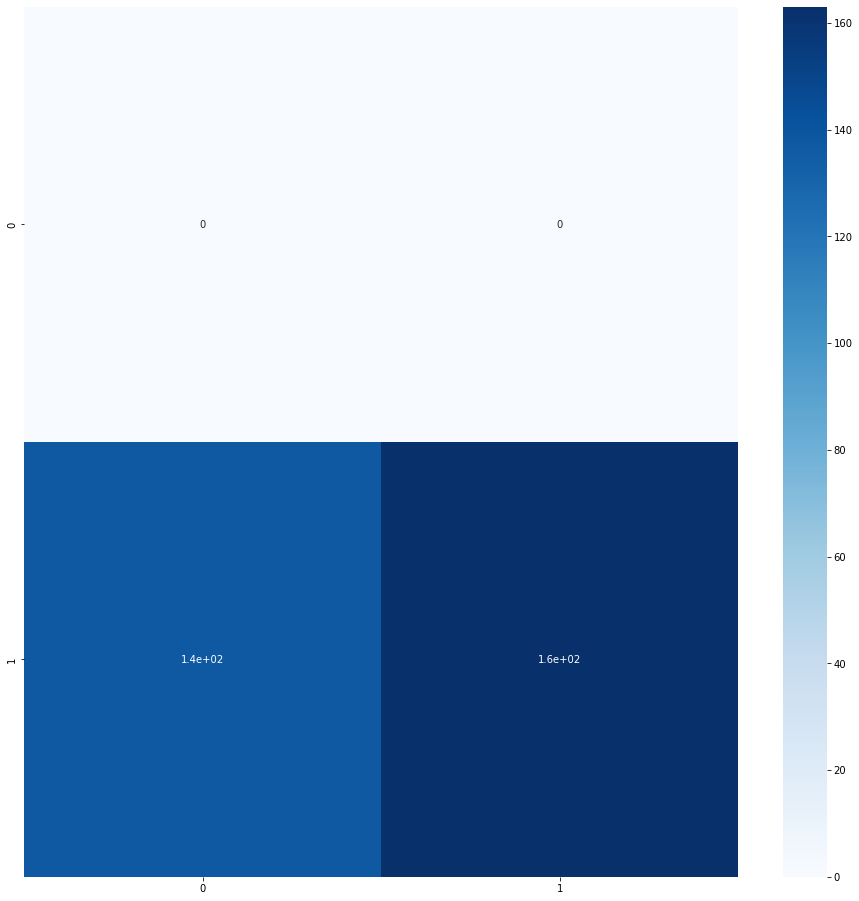

In [32]:
predicted_classes = np.argmax(model.predict(x_test), axis = 1)
confusionmatrix = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes))

In [33]:
loss,acc = model.evaluate(x_test,y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6011 - loss: 0.8034
